In [1]:
import os
import pandas as pd
from fastbook import *
from fastai.tabular.all import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from dtreeviz.trees import *
import sklearn

def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

traindf = pd.read_csv('/mnt/c/Users/jsult/Desktop/spacetitanic3/train.csv',low_memory=False)
testdf = pd.read_csv('/mnt/c/Users/jsult/Desktop/spacetitanic3/test.csv',low_memory= False)
traindf.dropna(inplace = True)





/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastbook/__init__.py:11: UserWarning: Missing `ipywidgets` - please install it
  except ModuleNotFoundError: warn("Missing `ipywidgets` - please install it")
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastbook/__init__.py:13: UserWarning: Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`
  except ModuleNotFoundError: warn("Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`")


In [2]:
nas = list(testdf.isna().sum(axis = 1))
indexes = list(testdf.index)
keepinds = []
dropinds = []
for i in range(len(indexes)):
    if nas[i] == 0:
        keepinds.append(i)
    else:
        dropinds.append(i)
droptest = testdf.loc[dropinds].copy()
testdf = testdf.loc[keepinds].copy()

In [3]:
spending = ['VRDeck','Spa','RoomService','FoodCourt','ShoppingMall']
traindf['TotalSpendingInCabin'] = traindf.groupby('Cabin')[spending].transform('sum').sum(axis=1)
testdf['TotalSpendingInCabin'] = testdf.groupby('Cabin')[spending].transform('sum').sum(axis=1)


In [4]:
def split_cabin(df):
    df['CabinDeck'] = df['Cabin'].apply(lambda x: x.split("/" )[0] if pd.notna(x) else pd.NA)
    df['CabinSide'] = df['Cabin'].apply(lambda x: x.split("/")[2] if pd.notna(x) else pd.NA)
    df['CabinNum'] = df['Cabin'].apply(lambda x: int(x.split("/")[1]) if pd.notna(x) else pd.NA)
    return df

traindf = split_cabin(traindf)
testdf= split_cabin(testdf)

/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/pyth

decision tree prediction 0.801665404996215


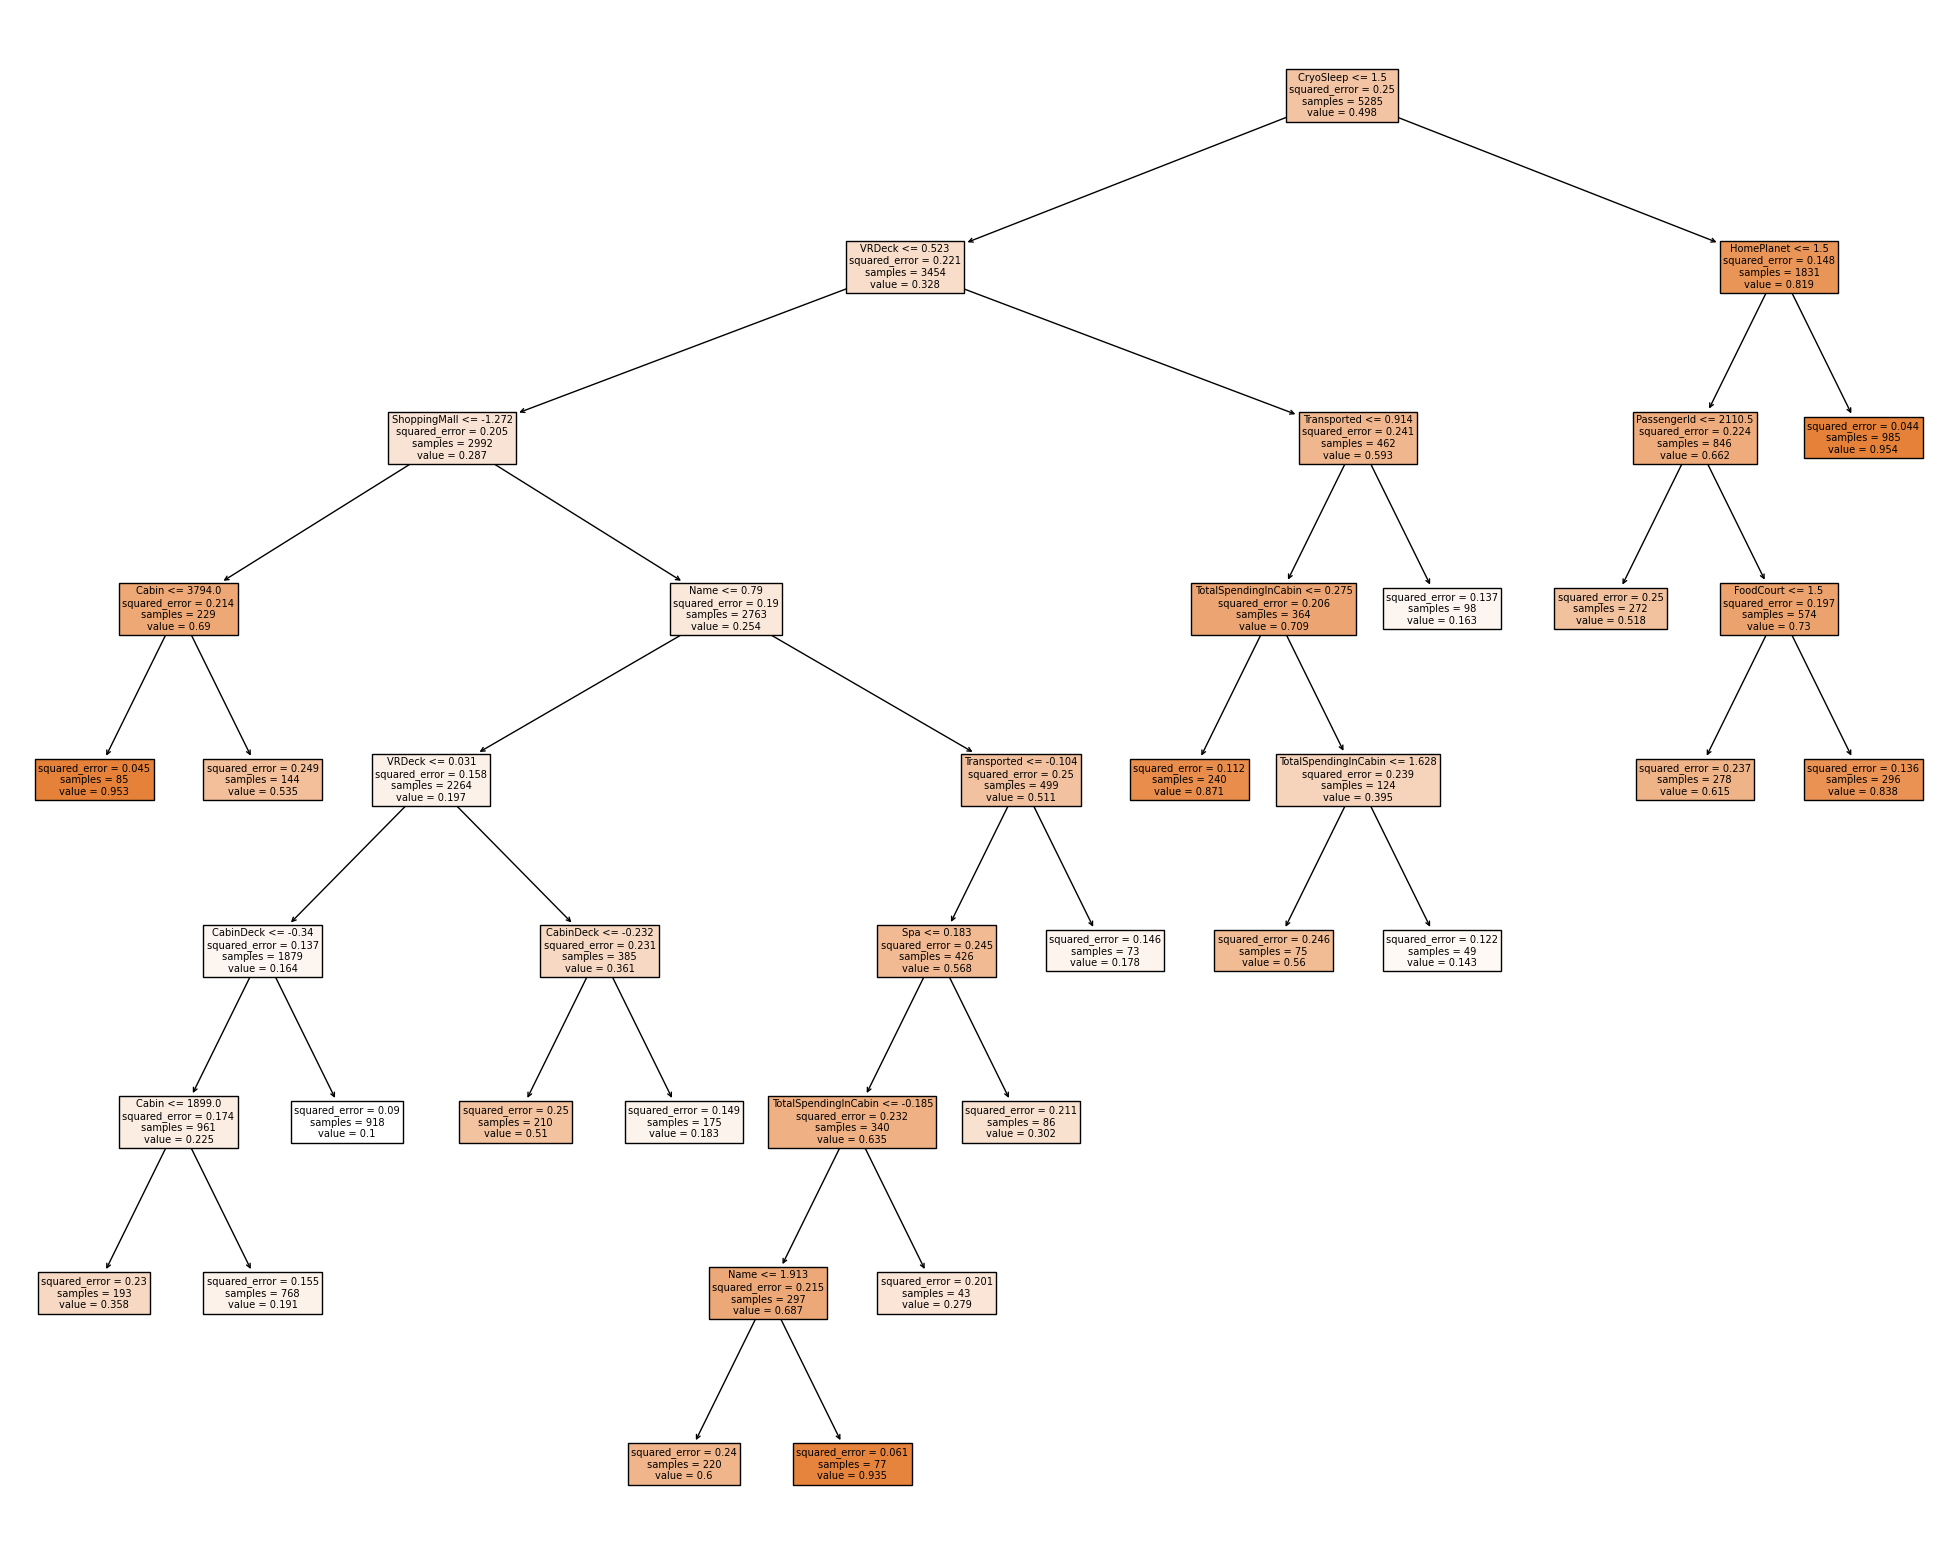

In [6]:



splits = RandomSplitter(seed = 1)(range_of(traindf))
dep_var = 'Transported'
procs = [Categorify,FillMissing,Normalize]
cont,cat = cont_cat_split(traindf, 1, dep_var=dep_var)
to = TabularPandas(traindf, procs, cat, cont, y_names=dep_var,splits = splits)

xs,y = to.train.xs,to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

m = DecisionTreeRegressor(max_leaf_nodes=20)
m.fit(xs, y)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(m,
                   feature_names= traindf.columns,
                   filled=True)

print('decision tree prediction',((m.predict(valid_xs) > 0.5) == valid_y).sum() / len(valid_y))




In [7]:



m = RandomForestClassifier(n_estimators= 100, max_leaf_nodes= 50)
m.fit(xs, y)
preds = m.predict(valid_xs)
print("mae",mean_absolute_error(valid_y, preds))
print('preds', (preds == valid_y).sum() /len(valid_y))




mae 0.19530658591975775
preds 0.8046934140802422


In [8]:
raindf = traindf.drop(columns = ['PassengerId','CabinNum','Cabin','Name'])
raindf = pd.get_dummies(raindf)
df_all_corr = raindf.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'CabinSide_P']

,Feature 1,Feature 2,Correlation Coefficient
1,CabinSide_P,CabinSide_S,1.000000
30,CabinSide_P,CabinSide_P,1.000000
326,CabinSide_P,Transported,0.106186
503,CabinSide_P,HomePlanet_Europa,0.046553
553,CabinSide_P,HomePlanet_Mars,0.030787
563,CabinSide_P,CabinDeck_C,0.029548
576,CabinSide_P,CabinDeck_F,0.026929
580,CabinSide_P,TotalSpendingInCabin,0.026918
589,CabinSide_P,CabinDeck_B,0.024783
608,CabinSide_P,FoodCourt,0.021578


In [9]:
traindf.columns
import seaborn as sns
sns.set(style="darkgrid")

/tmp/ipykernel_219277/2710552212.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
/tmp/ipykernel_219277/2710552212.py:10: UserWarning: 

`distplot` is a deprecated function and will be r

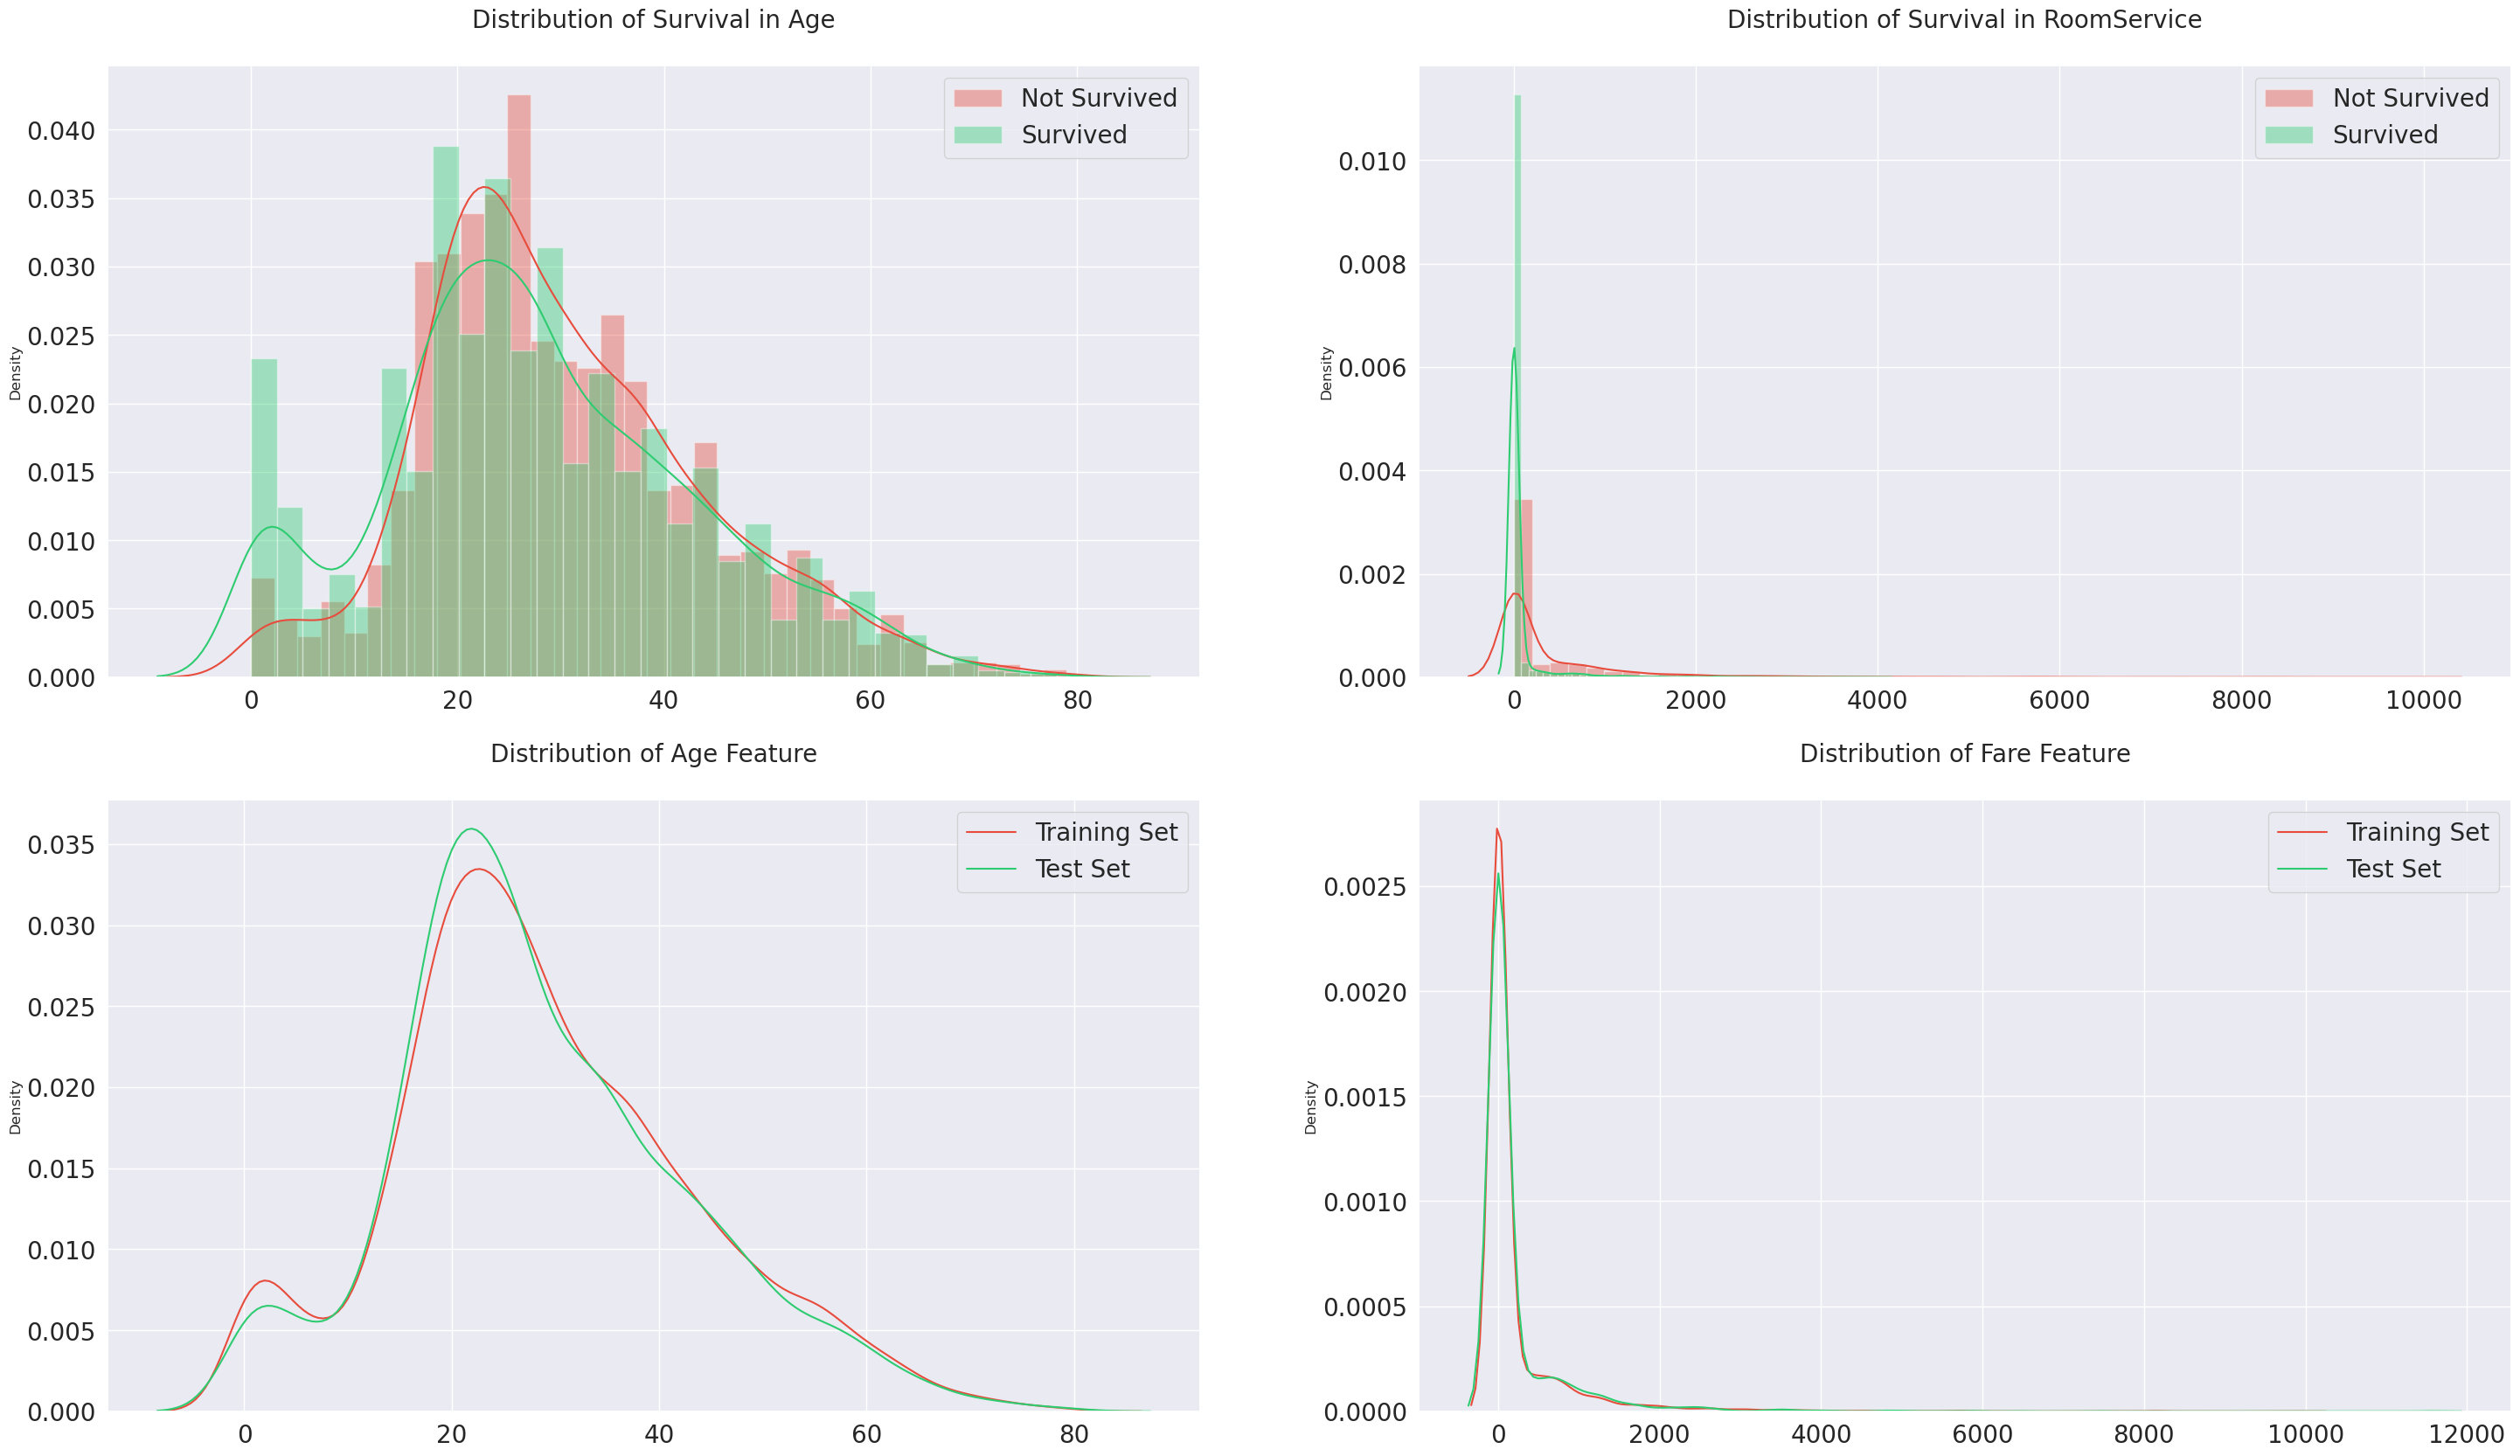

In [10]:
cont_features = ['Age', 'RoomService']
surv = traindf['Transported'] == 1

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):    
    # Distribution of survival in feature
    sns.distplot(traindf[~surv][feature], label='Not Survived', hist=True, color='#e74c3c', ax=axs[0][i])
    sns.distplot(traindf[surv][feature], label='Survived', hist=True, color='#2ecc71', ax=axs[0][i])
    
    # Distribution of feature in dataset
    sns.distplot(traindf[feature], label='Training Set', hist=False, color='#e74c3c', ax=axs[1][i])
    sns.distplot(testdf[feature], label='Test Set', hist=False, color='#2ecc71', ax=axs[1][i])
    
    axs[0][i].set_xlabel('')
    axs[1][i].set_xlabel('')
    
    for j in range(2):        
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
    
    axs[0][i].legend(loc='upper right', prop={'size': 20})
    axs[1][i].legend(loc='upper right', prop={'size': 20})
    axs[0][i].set_title('Distribution of Survival in {}'.format(feature), size=20, y=1.05)

axs[1][0].set_title('Distribution of {} Feature'.format('Age'), size=20, y=1.05)
axs[1][1].set_title('Distribution of {} Feature'.format('Fare'), size=20, y=1.05)
        
plt.show()

In [11]:



def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(m, xs)
print(fi[:30])





                    cols       imp
2              CryoSleep  0.201566
13                   Spa  0.136366
10           RoomService  0.105681
14                VRDeck  0.105190
11             FoodCourt  0.078301
15  TotalSpendingInCabin  0.073411
12          ShoppingMall  0.064026
3                  Cabin  0.057905
1             HomePlanet  0.039833
9                    Age  0.031123
7              CabinDeck  0.027787
16              CabinNum  0.025285
0            PassengerId  0.020366
6                   Name  0.013676
8              CabinSide  0.012613
4            Destination  0.006668
5                    VIP  0.000203


In [12]:





cont,cat = cont_cat_split(testdf, 1, dep_var=dep_var)
mode_values = testdf[cat].mode().iloc[0]
testdf[cat] = testdf[cat].fillna(mode_values)


for column in cont:
    mode_value = testdf[column].median()  # Calculate the mode for the column
    testdf[column].fillna(mode_value, inplace=True)  # Fill missing values with mode
    
to_new = to.train.new(testdf)
to_new.process()


testtran = [True if x == 1 else False for x in list(m.predict(to_new.xs))]
testdf['Transported'] = testtran

droptest['Transported'] = False
droptest = droptest[['PassengerId','Transported']]
testdf = testdf[['PassengerId','Transported']]

result = pd.concat([droptest,testdf])
result = result.sort_index()

result.to_csv('submit.csv',index=False)


/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3